# Example 3 - Sample Average Approximation

In [1]:
# Loading required packages
using JuMP
using HiGHS
using Distributions
using Plots
# Available from Base, just need to be loaded:
using LinearAlgebra
using Statistics
using Random
Random.seed!(1234);

TaskLocalRNG()

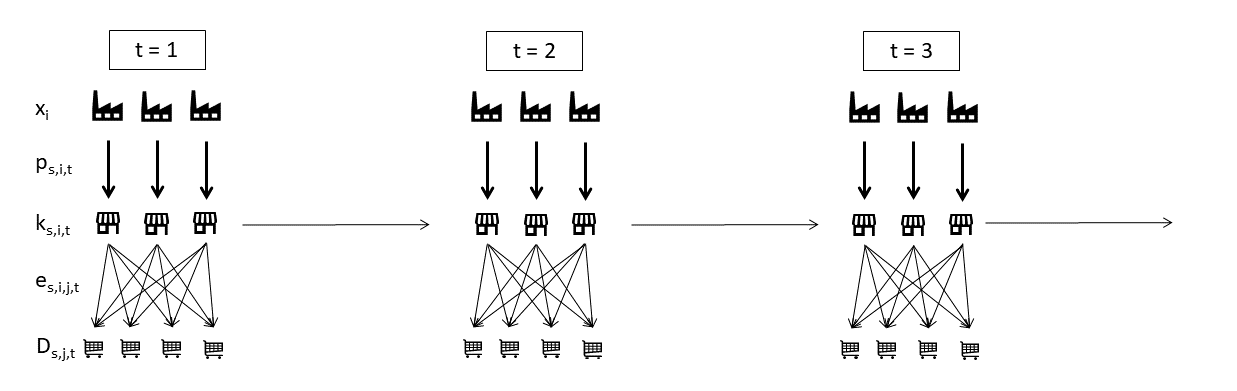

We consider a lot-sizing problem under demand uncertainty. Let
- $I$ - set of suppliers
- $J$ - set of clients
- $S$ - set of scenarios
- $T$ - set of time periods
- $P_s$ - probability of scenario $s\in S$
- $C_{i}$ - unit capacity cost for supplier $i \in I$
- $H_{i}$ - unit storage cost for supplier $i \in I$
- $M_{i}$ - unit production cost for supplier $i \in I$
- $D_{s,j,t}$ - scenario $s \in S$ demand for client $j \in J$ and period $t \in T$
- $Q_{j}$ - unit cost for unfulfilled demand at client $j \in J$
- $F_{i,j}$ - unit cost for supplier $i \in I$ fulfilling client $j \in J$
- $x_i$ - capacity per supplier $i \in I$ 
- $p_{s,i,t}$ -units produced per supplier $i \in I$, period $t \in T$, and scenario $s \in S$ 
- $k_{s,i,t}$ - units stored in each supplier $i \in I$, in period $t \in T$, and scenario $s \in S$
- $e_{s,i,j,t}$ - units transported from supplier $i \in I$ to client $j \in J$ in period $t \in T$, and scenario $s \in S$
- $u_{s, j, t}$ - unfulfilled demand per client $j \in J$, in period $t \in T$, and scenario $s \in S$

Our problem can be formulated as:

\begin{align*}
    \min_{x,k,p,e,u \ge 0}~& \sum_{i \in I} C_i x_i + \sum_{s \in S} P_s\left( \sum_{i \in I, t \in T} (H_i k_{s,i,t} + M_{i} p_{s,i,t}) + \sum_{i \in I, j \in J, t \in T} F_{i,j}e_{s,i,j,t} + \sum_{j \in J, t \in T} Q_{j}u_{s,j,t} \right) \\
    \text{s.t.: } & p_{s,i,t} \le x_{i}, &&\ \forall s \in S, i \in I, t \in T \\
    & p_{s,i,t} + k_{s,i,t-1} = \sum_{j \in J}e_{s,i,j,t}  + k_{s,i,t}, &&\ \forall s \in S, i \in I, t \in T \\
    & \sum_{i \in I} e_{s,i,j,t} = D_{s,j,t} - u_{s,j,t}, &&\ \forall s \in S, j \in J, t \in T.
\end{align*}

We define some auxiliary structures to aid moving data between problems. The function `unroll` simply "opens" the structure `Instance` so we can avoid adding `Instance.` before our parameters

In [2]:
#= 
These structures will ease the passing of the specific instance for the functions 
that generate and solve the optimization model.
=#
mutable struct Instance
    nI     # Number of suppliers      
    nJ     # Number of clients
    nT     # Number of periods
    I      # Supplier range
    J      # Client range
    T      # Periods range
    C      # Unit capacity costs per supplier
    H      # Unit storage cost per supplier
    M      # Production cost per supplier
    D      # Client demands in all periods
    Q      # Unit costs of unfulfilled demand
    F      # Unit costs to fulfil demands 
end

mutable struct ScenarioTree
    D      # Random demand 
    P      # Probabaility 
end

function unroll(Instance)
    I = Instance.I
    J = Instance.J
    T = Instance.T 
    C = Instance.C
    H = Instance.H
    M = Instance.M
    Q = Instance.Q
    F = Instance.F
    return I, J, T, C, H, M, Q, F
end    

unroll (generic function with 1 method)

The function `create_scenarios` generates a given of demand scenarios. Notice some characteristics of them:
- They all have the same probabiliy $\frac{1}{nS}$
- The scenarios are first-order auto regressive series, sampled for all time periods


In [3]:
# Scenario generation
function create_scenarios(ins::Instance, nS)

    ## Renaming for making the implementation clearer
    nJ = ins.nJ
    nT = ins.nT
    J = ins.J
    T = ins.T 
    D = ins.D
    
    S  = 1:nS                 # scenario set
    P = repeat([1/nS],nS )   # scenario probability

    ## d_sto: Stochastic demand
    D_sto = zeros(nS, size(D)[1], size(D)[2])    

    ## Setting up the Monte Carlo simulation
    μ = 0.10                            # Expected demand growth
    σ = 0.05                            # Max variability
    ϵ = randn(nS,nJ,nT)                 # This is the variability, following a standard normal 

    ## Assigning stochastic values
    for s in S
        D_sto[s,:,1] = D[:,1]
        for j in J
            for t in T[T.>1]
                D_sto[s,j,t] =  (1 + μ + σ * ϵ[s,j,t]) * D_sto[s,j,t-1]
            end
        end
    end
    return ScenarioTree(D_sto, P)
end;


In [4]:
# Create problem data
## Problem data
nI = 15                                # Number of suppliers      
nJ = 15                                # Number of demand points
nT = 10                                # Number of periods
I = 1:nI                               # Supplier range
J = 1:nJ                               # Demand points range
T = 1:nT                               # Periods range

## Generate random data for the problem
C = rand(400:1000, nI)                 # Unit capacity costs per supplier
H = rand(1:2, nI)                      # Unit storage cost per supplier
M = rand(20:40, nI)                    # Production cost per supplier
D = repeat(rand(100:250, nJ),1,nT)     # Client demands in all periods
D = (D'.*[1.05^(t-1) for t in 1:nT])'  # Adding a trend to demand
Q = rand(250:500, nJ)                  # Unit costs of unfulfilled demand
F = rand(6:30, (nI,nJ))                # Unit costs to fulfill demands

# This packages the problem instance information into a single structure.
ins = Instance(nI, nJ, nT, I, J, T, C, H, M, D, Q, F);

$\eta$ is our reference sample, which we will use for out-of-sample testing, reducing and approximating via SAA. In our case, it plays the role of the *truthful* stochastic process.

In [5]:
η = create_scenarios(ins, 1000);

Let's have a look at some of our scenarios

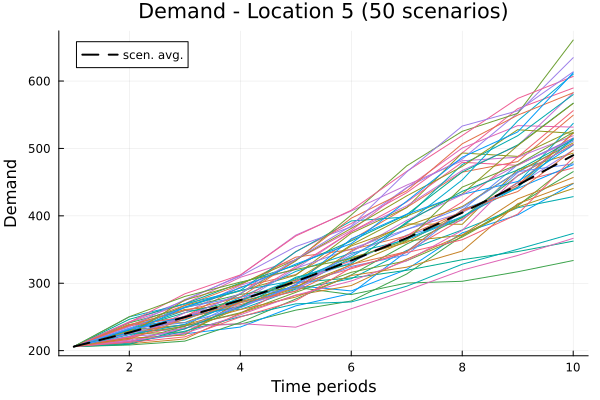

In [6]:
# Plotting the scenarios for a single locatiom
j = 5   # selected location for plotting
nS = 50 # number of samples to visualise 

# Creating empty plot
plot(
    xlabel = "Time periods",
    ylabel = "Demand",  
    title = "Demand - Location $(j) ($(50) scenarios)",
)

# Including each demand series in the plot
for s in 1:nS                               
    plot!(η.D[s,j,:], label = "")
end

# Plotting the expected demand 
plot!([mean(η.D[:,j,t]) for t in T], 
    lw = 2,          # line weight
    ls = :dash,      # line stroke
    color = :black, 
    label = "scen. avg."
)

The functions `generate_stochastic(ins, ξ)` and `solve_stochastic(model; verbose=true)` are meant to separate the process of generating and solving the model.

In [7]:
#=
generate_stochastic(ins, ξ): 
inputs:
    1. ins: data instance (::Instance)
    2. ξ: scenario tree (::ScenTree)
output:
    1. 2SSP model (::JuMP)
=#
function generate_stochastic(ins, ξ)

    # Renaming for making the implementation clearer    
    I, J, T, C, H, M, Q, F = unroll(ins)
    
    D_sto = ξ.D
    P = ξ.P
    nS = length(P)   # total of scenarios in ξ
    S = 1:nS          # set of scenarios 

    model = Model(HiGHS.Optimizer)      

    # Variables
    @variable(model, x[i ∈ I] ≥ 0)                          # Capacity per supplier (independent on the scenarios realisation)
    @variable(model, p[s ∈ S, i ∈ I, t ∈ T] ≥ 0)            # Units produced per supplier i, per period t, and scenario sc
    @variable(model, k[s ∈ S, i ∈ I, t ∈ T] ≥ 0)            # Units stored in each supplier i, period t, and scenario sc
    @variable(model, e[s ∈ S, i ∈ I, j ∈ J, t in T] ≥ 0)    # Units transported from supplier i to demand point j at period t and scenario sc
    @variable(model, u[s ∈ S, j ∈ J, t ∈ T] ≥ 0)            # Unfulfilled demand per demand point j, period t, and scenario sc

    # Objective: Minimize the total first-stage + second-stage costs over all scenarios
    @objective(model, Min,
      sum(C[i] * x[i] for i in I) +
      sum(P[s] * H[i] * k[s,i,t] for s in S, t in T, i in I) + 
      sum(P[s] * M[i] * p[s,i,t] for s in S, t in T, i in I) +
      sum(P[s] * F[i,j] * e[s,i,j,t] for s in S, t in T, i in I, j in J) + 
      sum(P[s] * Q[j] * u[s,j,t] for s in S, t in T, j in J) 
    )

    # Constraints
    #Capacity limit for each supplier i in each period t
    @constraint(model, Cap[s in S, i in I, t in T], p[s,i,t] <= x[i])
    # Supply balance constraint
    # (T=1): First period do not count with previous stocks
    @constraint(model, SupBal1[s in S, i in I, t in [1]], p[s,i,t] == sum(e[s,i,j,t] for j in J) + k[s,i,t])
    # (T>1): All periods but the first are balanced with the storage levels decided in the previous periods
    @constraint(model, SupBal2[s in S, i in I, t in T[T.>1]], p[s,i,t] + k[s,i,t-1] == sum(e[s,i,j,t] for j in J) + k[s,i,t])
    # Demand balance constraint (u[j,s] is unfulfilled demand of client j in scenario s)
    @constraint(model, DemBal[s in S, j in J, t in T], sum(e[s,i,j,t] for i in I) == D_sto[s,j,t] - u[s,j,t])
    
    return(model)
end

#=
solve_stochastic(model; verbose=true):
- inputs
    1. model: the 2SSP model
    2. verbose: hide solver log
-outputs
    1. x_val: first-stage solution
    2. obj: objective function value
=#

function solve_stochastic(model; verbose=true)
    if verbose 
        println("Solving stochastic model...")    
    else
        set_silent(model)                      # Omit solver log
    end
    optimize!(model)                           # Solve the problem

    status = termination_status(model)         # Solution status
    
    if verbose 
        println(status)                        # Print status
    end
    
    x_val = Array(value.(model[:x]))
    obj = objective_value(model)
    # Returns first-stage solution and objective value
    return (x_val, obj)
end;    

These are important auxiliary functions. 
- `sample_scenarios(η, N)` generate `N` random samples from `η`. The sampling is purely Monte Carlo-like. We simply shuffle the positions and take the first `N` elements
- `calculate_ci(x; conf_level=0.95)` calculates confidence intervals given a vector of realisations of `x`. It assumes a default confidence level of 95%.

In [8]:
#=
sample_scenarios(η, N):
- inputs 
    1. η: original full length (discrete stochastic process)
    2. N: desired number of sample_scenarios
- output
    1. ScenarioTree(D_aux, P_aux):" a scenario tree ξ of size N    
=#
function sample_scenarios(η, N)
    nS = length(η.P)
    sample = shuffle([ones(N); zeros(nS-N)])
    
    P_aux = repeat([1/N], N)
    D_aux = zeros(N, size(η.D[1,:,:])[1], size(η.D[1,:,:])[2])
    m = 1
    for s in 1:nS
        if sample[s] > 0.0
            D_aux[m,:,:] .= η.D[s,:,:]
            m += 1
        end
    end    
    return ScenarioTree(D_aux, P_aux)
end;   

#=
calculate_ci(x; α=0.95):
- inputs 
    1. x: observations of random variable x::Vector
    2. conf_level=0.95: desired confidence level 1 - α
- output
    1. low: confidence interval lower bound
    2. high: confidence interval upper bound  
=#
function calculate_ci(x; conf_level=0.95)
    α = (1 - conf_level)
    z = quantile(Normal(), 1 - α/2)
    SE = std(x)/sqrt(length(x))
    low, high = mean(x) .+ [-1, 1] * z * SE
    return low, high
end;

## Calculating SAA lower bound

To calculate the approximation for the lower bound $L_N^M$, we must:
1. Define scenario tree sizes $N$ and the number of repetitions $M$
2. Solve each of the $m \in M$ subproblems and obtain $\hat{z}^m_N$
3. Calculate the bound:
\begin{equation*}
	L_N^M = \frac{1}{M} \sum_{m=1}^M \hat{z}^m_N.
\end{equation*}

Notice that we also keep track of the solutions we obtain for each subproblem $m \in M$

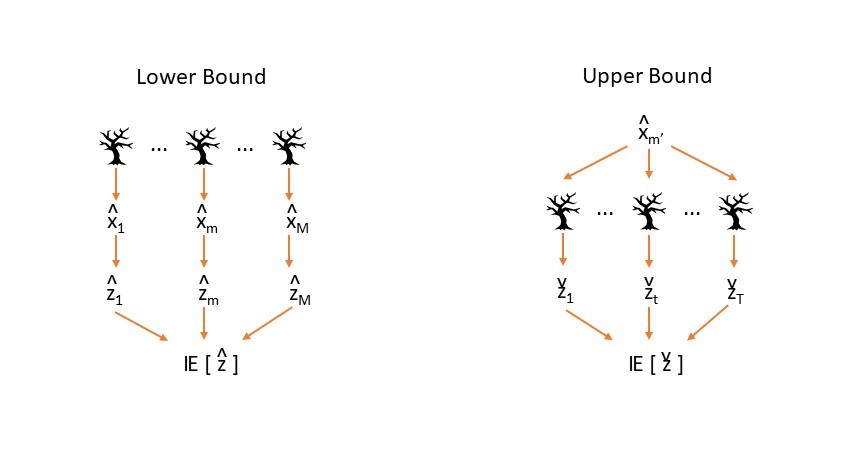

In [9]:
N = 10
M = 20

# Main SAA lower bound loop
solutions = []
bounds = [] # \hat{z}
for m = 1:M
    if mod(m, 5) == 0
        println("Solving problem m = $(m) of $(M)")
    end    
    ξ = sample_scenarios(η, N)
    model = generate_stochastic(ins, ξ)
    (x, obj) = solve_stochastic(model, verbose=false)
    push!(solutions, x)
    push!(bounds, obj)   
end 

println("lower bound = ", mean(bounds))
println("relative deviation = ", sqrt(var(bounds, corrected=true))/mean(bounds) * 100, "%")
println("CI = ", calculate_ci(bounds))

Solving problem m = 5 of 20
Solving problem m = 10 of 20
Solving problem m = 15 of 20
Solving problem m = 20 of 20
lower bound = 4.2019889248454105e6
relative deviation = 0.8951901357098486%
CI = (4.185503380779849e6, 4.218474468910973e6)


## Calculating SAA upper bound

To calculate the upper bound, it will be useful to have a version of our model that we can submit a first-stage solution to be evaluated for a given scenario $s \in S$. This is the purpose of `generate_scenario_fixed(ins, D_s, x_solution)`.

In [10]:
#=
generate_scenario_fixed(ins, D_s, x_solution):
- inputs
  1. ins: data instance (::Instance)
  2. D_s: a single demand scenario
  3. x_solution: the solution to be evaluated
- outputs
  1. model: a deterministic single-scenario model (::JuMP)
=#
function generate_scenario_fixed(ins, D_s, x_solution)
    
    # Renaming for making the implementation clearer    
    I, J, T, C, H, M, Q, F = unroll(ins)
    
    model = Model(HiGHS.Optimizer)      

    # Variables
    @variable(model, x[i in I] >= 0)                    # Capacity per supplier (independent on the scenarios realisation)
    @variable(model, p[i in I, t in T] >= 0)            # Units produced per supplier i, per period t, and scenario sc
    @variable(model, k[i in I, t in T] >= 0)            # Units stored in each supplier i, period t, and scenario sc
    @variable(model, e[i in I, j in J, t in T] >= 0)    # Units transported from supplier i to demand point j at period t and scenario sc
    @variable(model, u[j in J, t in T] >= 0)            # Unfulfilled demand per demand point j, period t, and scenario sc

    # Objective: Minimize the total first-stage + second-stage costs over all scenarios
    @objective(model, Min,
      sum(C[i] * x[i] for i in I) +
      sum(H[i] * k[i,t] for t in T, i in I) + 
      sum(M[i] * p[i,t] for t in T, i in I) +
      sum(F[i,j] * e[i,j,t] for t in T, i in I, j in J) + 
      sum(Q[j] * u[j,t] for t in T, j in J) 
    )

    # Constraints
    # Capacity limit for each supplier i in each period t
    @constraint(model, Cap[i in I, t in T], p[i,t] <= x[i])

    # Supply balance constraint
    # (T=1): First period do not count with previous stocks
    @constraint(model, SupBal1[i in I, t in [1]], p[i,t] == sum(e[i,j,t] for j in J) + k[i,t])
    # (T>1): All periods but the first are balanced with the storage levels decided in the previous periods
    @constraint(model, SupBal2[i in I, t in T; t > 1], p[i,t] + k[i,t-1] == sum(e[i,j,t] for j in J) + k[i,t])
    # Demand balance constraint (u[j,s] is unfulfilled demand of client j in scenario s)
    @constraint(model, DemBal[j in J, t in T], sum(e[i,j,t] for i in I) == D_s[j,t] - u[j,t])
    
    # Fix first-stage solution to be x_solution
    @constraint(model, Fix1stStage[i in I], x[i] == x_solution[i])
    
    return(model)
end;

To calculate the approximation for the upper bound $\check{z}_{\overline{N}}^t$ we proceed by:
1. Choose a solution $\hat{x}^{m'}_N$ among the $|M|$ (potentially) distinct solutions
2. Evaluate each of the $t \in T$ subproblems using $\overline{N}$ scenarios, obtaining  
\begin{equation*}
	\check{z}_{\overline{N}}^t = \frac{1}{\overline{N}} \sum_{n=1}^{\overline{N}} F(\hat{x}^{m'}_N, \xi_n^t)
\end{equation*}
3. Calculate the upper bound estimate using
\begin{equation*}
	U_{\overline{N}}^T = \frac{1}{T} \sum_{t=1}^T \check{z}_{\overline{N}}^t.
\end{equation*}

We will, however, proceed slightly differently. Since we have a two-stage problem, fixing $x$ results in a number of independently solvable single stage subproblems, which can easily be solved. We can therefore alternatively calculate the upper bound against the whole set $\eta$. Thus, our estimate becomes
\begin{equation*}
	U_\eta = \frac{1}{|\eta|} \sum_{s=1}^{|\eta|} F(\hat{x}^{m'}_N, \eta_s).
\end{equation*}

Notice how similar this is to the idea of evaluating the scenario tree $\xi_N^{m'}$.





In [11]:
nObservations = length(η.P)
scen_costs = zeros(nObservations) # F(...)

# We choose our candidate solution by simply picking that with maximum LB
LB, candidate = findmax(bounds)

println("Evaluating solution $(candidate):")
for scenario in 1:nObservations
    if mod(scenario, 50) == 0  && scenario > 1 
      # print every 50 iterations
      println("Solved $(scenario) scenarios out of $(nObservations)") 
    end  
    model = generate_scenario_fixed(ins, η.D[scenario,:,:], solutions[candidate])
    ⋅, obj = solve_stochastic(model, verbose=false)
    scen_costs[scenario] = obj
end    

Evaluating solution 15:
Solved 50 scenarios out of 1000
Solved 100 scenarios out of 1000
Solved 150 scenarios out of 1000
Solved 200 scenarios out of 1000
Solved 250 scenarios out of 1000
Solved 300 scenarios out of 1000
Solved 350 scenarios out of 1000
Solved 400 scenarios out of 1000
Solved 450 scenarios out of 1000
Solved 500 scenarios out of 1000
Solved 550 scenarios out of 1000
Solved 600 scenarios out of 1000
Solved 650 scenarios out of 1000
Solved 700 scenarios out of 1000
Solved 750 scenarios out of 1000
Solved 800 scenarios out of 1000
Solved 850 scenarios out of 1000
Solved 900 scenarios out of 1000
Solved 950 scenarios out of 1000
Solved 1000 scenarios out of 1000


We are ready to calculate our upper bound estimate.

In [12]:
UB = mean(scen_costs)
println("upper bound = ",UB)
println("relative deviation = ",sqrt(var(scen_costs, corrected=true))/mean(scen_costs) * 100, "%")
println("CI = ",calculate_ci(scen_costs))
println("gap = ",100 * (UB - LB)/UB, "%") 

upper bound = 4.232360977064645e6
relative deviation = 1.5009526834101365%
CI = (4.228423683526284e6, 4.236298270603006e6)
gap = -1.1038432900264377%


We can experiment with the sample size $N$ to see the effect on the estimated bound. As expected, the bound gradually increases as we increase the sample size.

In [13]:
N_values = [5, 15, 30, 50]
M = 20

lower_bound = []
relative_deviation = []

for N in N_values
    # Main SAA lower bound loop
    solutions = []
    bounds = []
    println("Calculating N = $(N)")
    for m = 1:M
        if mod(m, 5) == 0
            println("   Solving problem m = $(m) of $(M)")
        end    
        ξ = sample_scenarios(η, N)
        model = generate_stochastic(ins, ξ)
        (x, obj) = solve_stochastic(model, verbose=false)
        push!(solutions, x)
        push!(bounds, obj)   
    end 

    push!(lower_bound, mean(bounds))
    push!(relative_deviation, sqrt(var(bounds, corrected=true))/mean(bounds) * 100)
end 

Calculating N = 5
   Solving problem m = 5 of 20
   Solving problem m = 10 of 20
   Solving problem m = 15 of 20
   Solving problem m = 20 of 20
Calculating N = 15
   Solving problem m = 5 of 20
   Solving problem m = 10 of 20
   Solving problem m = 15 of 20
   Solving problem m = 20 of 20
Calculating N = 30
   Solving problem m = 5 of 20
   Solving problem m = 10 of 20
   Solving problem m = 15 of 20
   Solving problem m = 20 of 20
Calculating N = 50
   Solving problem m = 5 of 20
   Solving problem m = 10 of 20
   Solving problem m = 15 of 20
   Solving problem m = 20 of 20


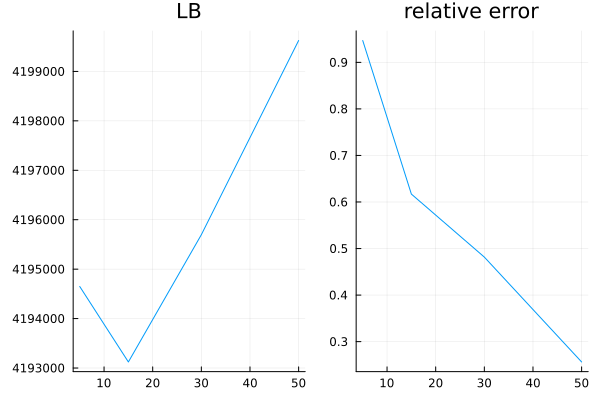

In [14]:
p1 = plot(N_values, lower_bound, title = "LB")
p2 = plot(N_values, relative_deviation, title = "relative error")
plot(p1, p2, layout=(1,2), legend = false)